## Prepare Notebook

In [1]:
import os
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import pytensor.tensor as pt
import seaborn as sns

from linearmodels.iv import IV2SLS

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
seed: int = sum(map(ord, "double_ml_bart"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
random_seed_int: int = rng.integers(low=0, high=100, size=1).item()

## Read Data

In [3]:
root_path = "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/"
data_path = os.path.join(root_path, "app_engagement_push.csv")

df = pd.read_csv(data_path)

n = df.shape[0]

df.head()

,in_app_purchase,push_assigned,push_delivered
0,47,1,1
1,43,1,0
2,51,1,1
3,49,0,0
4,79,0,0


## EDA

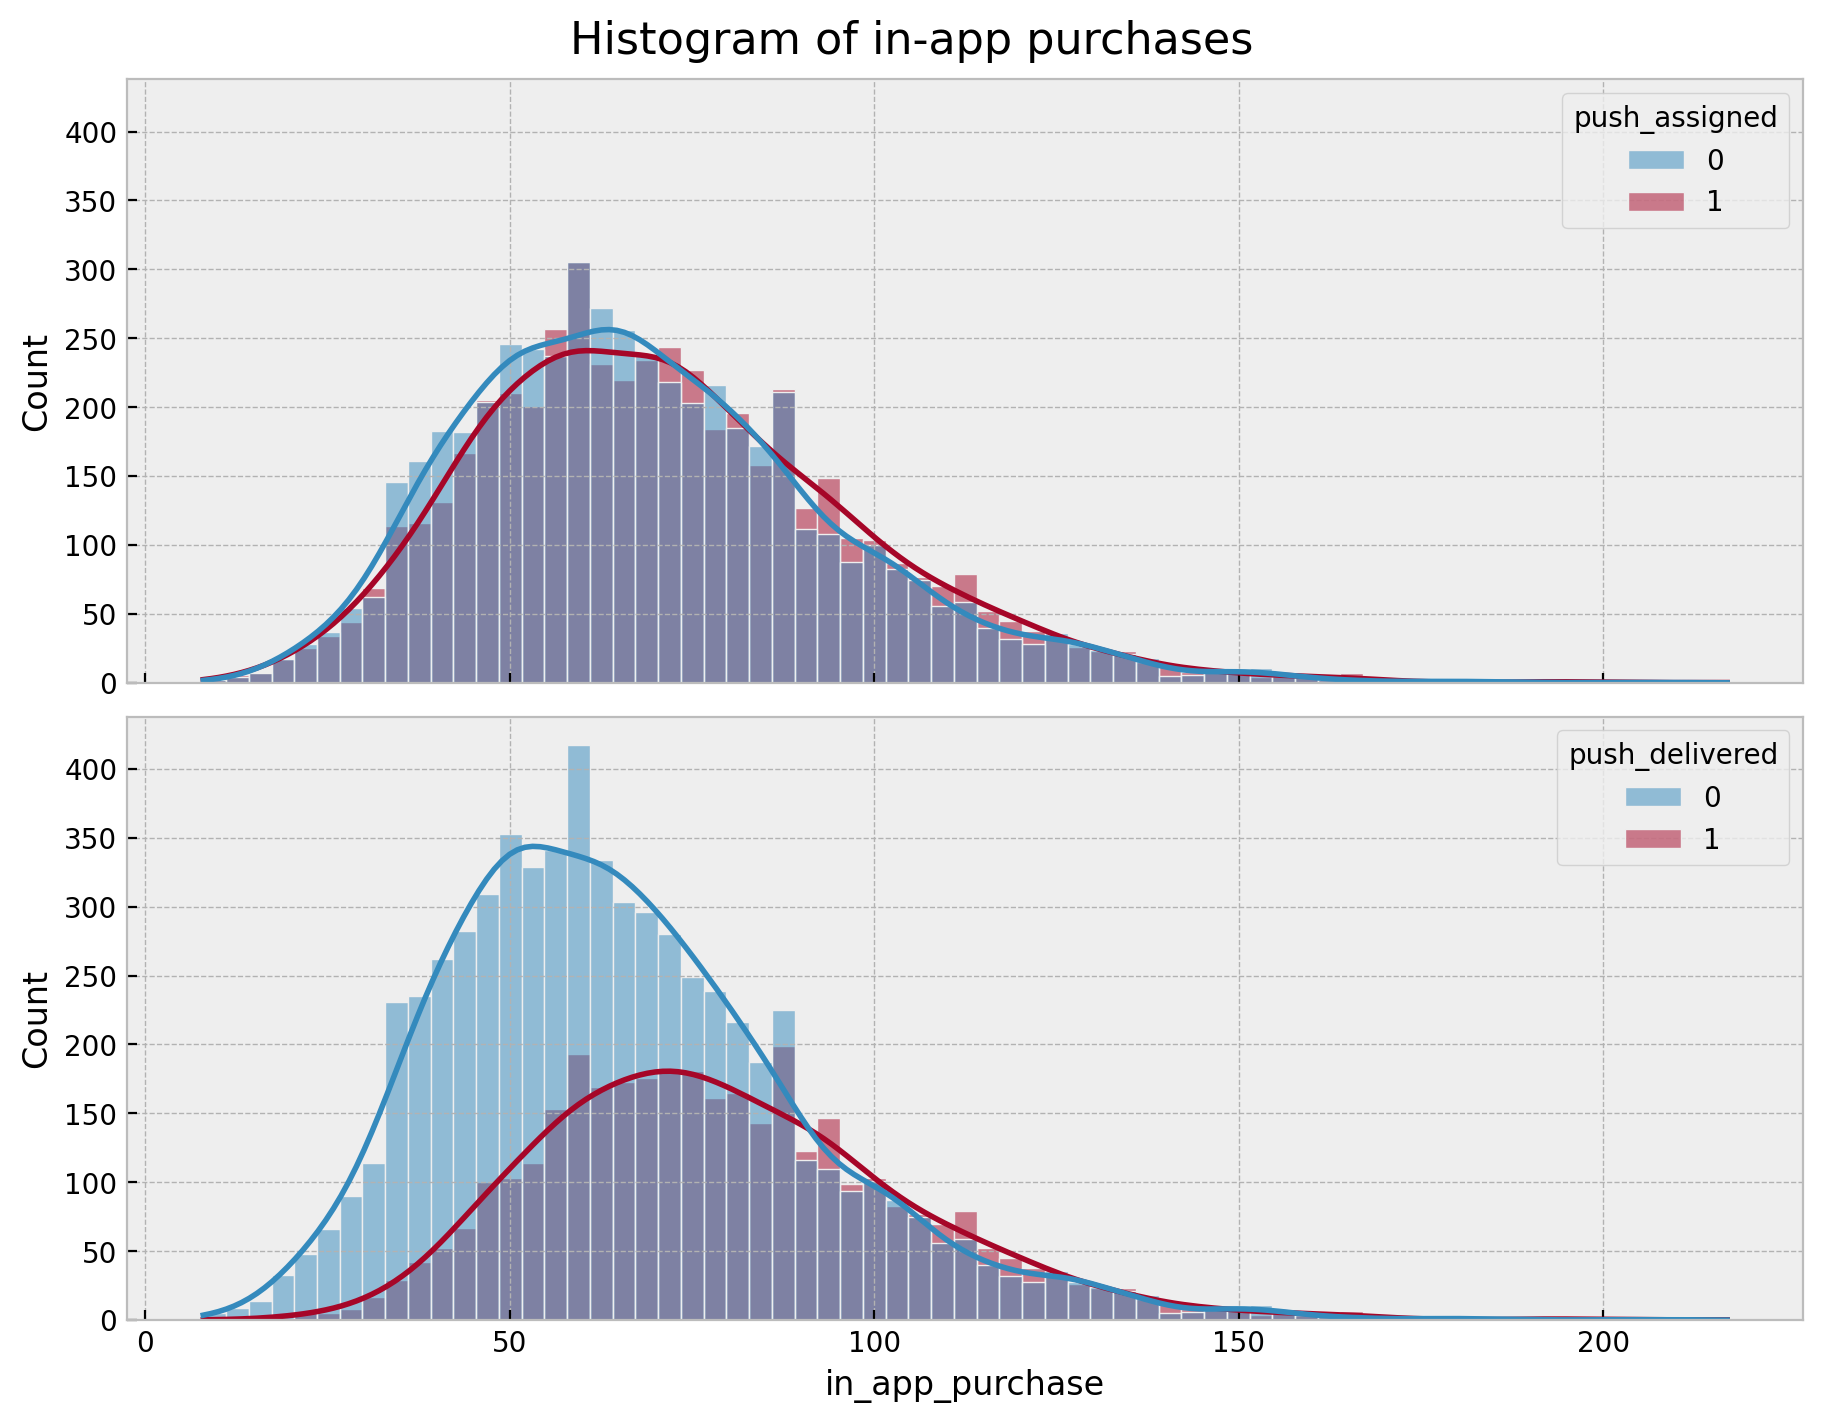

In [4]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(9, 7), sharex=True, sharey=True, layout="constrained"
)
sns.histplot(x="in_app_purchase", hue="push_assigned", kde=True, data=df, ax=ax[0])
sns.histplot(x="in_app_purchase", hue="push_delivered", kde=True, data=df, ax=ax[1])
fig.suptitle("Histogram of in-app purchases", fontsize=16);

In [5]:
df.groupby("push_assigned").agg({"in_app_purchase": ["mean", "std"]})

in_app_purchase           
                         mean        std
push_assigned                           
0                   69.291675  25.771624
1                   71.655270  26.310248

In [6]:
ols_formula = "in_app_purchase ~ 1 + push_assigned"
ols = IV2SLS.from_formula(formula=ols_formula, data=df).fit()
ols.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,2.3636,0.5209,4.5376,0.0000,1.3427,3.3845


In [7]:
df.groupby("push_delivered").agg({"in_app_purchase": ["mean", "std"]})

in_app_purchase           
                          mean        std
push_delivered                           
0                    65.518519  25.111324
1                    79.449958  25.358723

In [8]:
ols_formula = "in_app_purchase ~ 1 + push_delivered"
ols = IV2SLS.from_formula(formula=ols_formula, data=df).fit()
ols.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,65.519,0.3126,209.61,0.0000,64.906,66.131
push_delivered,13.931,0.5282,26.377,0.0000,12.896,14.967


In [9]:
iv_formula = "in_app_purchase ~ 1 + [push_delivered ~ push_assigned]"
iv = IV2SLS.from_formula(formula=iv_formula, data=df).fit()
iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_delivered,3.2938,0.7165,4.5974,0.0000,1.8896,4.6981


In [10]:
y = df["in_app_purchase"].to_numpy()
t = df["push_delivered"].to_numpy()
z = df["push_assigned"].to_numpy()

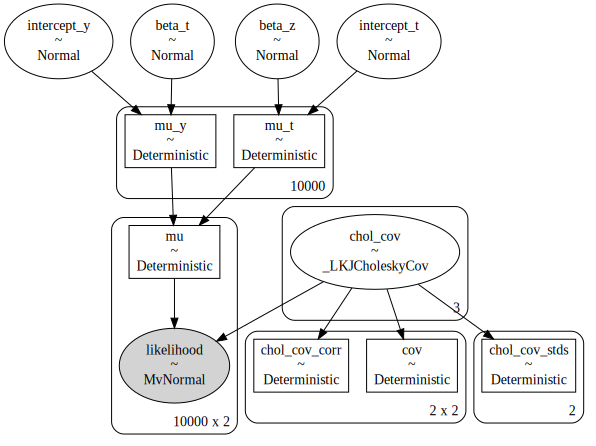

In [11]:
with pm.Model() as model:
    intercept_y = pm.Normal(name="intercept_y", mu=50, sigma=10)
    intercept_t = pm.Normal(name="intercept_t", mu=0, sigma=1)
    beta_t = pm.Normal(name="beta_t", mu=0, sigma=10)
    beta_z = pm.Normal(name="beta_z", mu=0, sigma=10)
    sd_dist = pm.HalfCauchy.dist(beta=2, shape=2)
    chol, corr, sigmas = pm.LKJCholeskyCov(name="chol_cov", eta=2, n=2, sd_dist=sd_dist)

    pm.Deterministic(name="cov", var=pt.dot(l=chol, r=chol.T))
    
    mu_y = pm.Deterministic(name="mu_y", var=beta_t * t + intercept_y)
    mu_t = pm.Deterministic(name="mu_t", var=beta_z * z + intercept_t)
    mu = pm.Deterministic(name="mu", var=pt.stack(tensors=(mu_y, mu_t), axis=1))
    
    likelihood = pm.MvNormal(
        name="likelihood",
        mu=mu,
        chol=chol,
        observed=np.stack(arrays=(y, t), axis=1),
        shape=(n, 2),
    )

pm.model_to_graphviz(model=model)


In [12]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(draws=2_000, chains=4)

Compiling...
Compilation time =  0:00:05.763649
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:31.376427
Transforming variables...
Transformation time =  0:00:03.691176


In [13]:
var_names = ["beta_t", "beta_z", "intercept_y", "intercept_t"]

az.summary(data=idata, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_t,3.304,0.709,1.971,4.635,0.013,0.009,3108.0,5023.0,1.0
beta_z,0.718,0.006,0.706,0.729,0.000,0.000,4740.0,5660.0,1.0
intercept_y,69.279,0.357,68.620,69.972,0.006,0.004,3683.0,5054.0,1.0
intercept_t,-0.000,0.004,-0.008,0.008,0.000,0.000,5283.0,5935.0,1.0


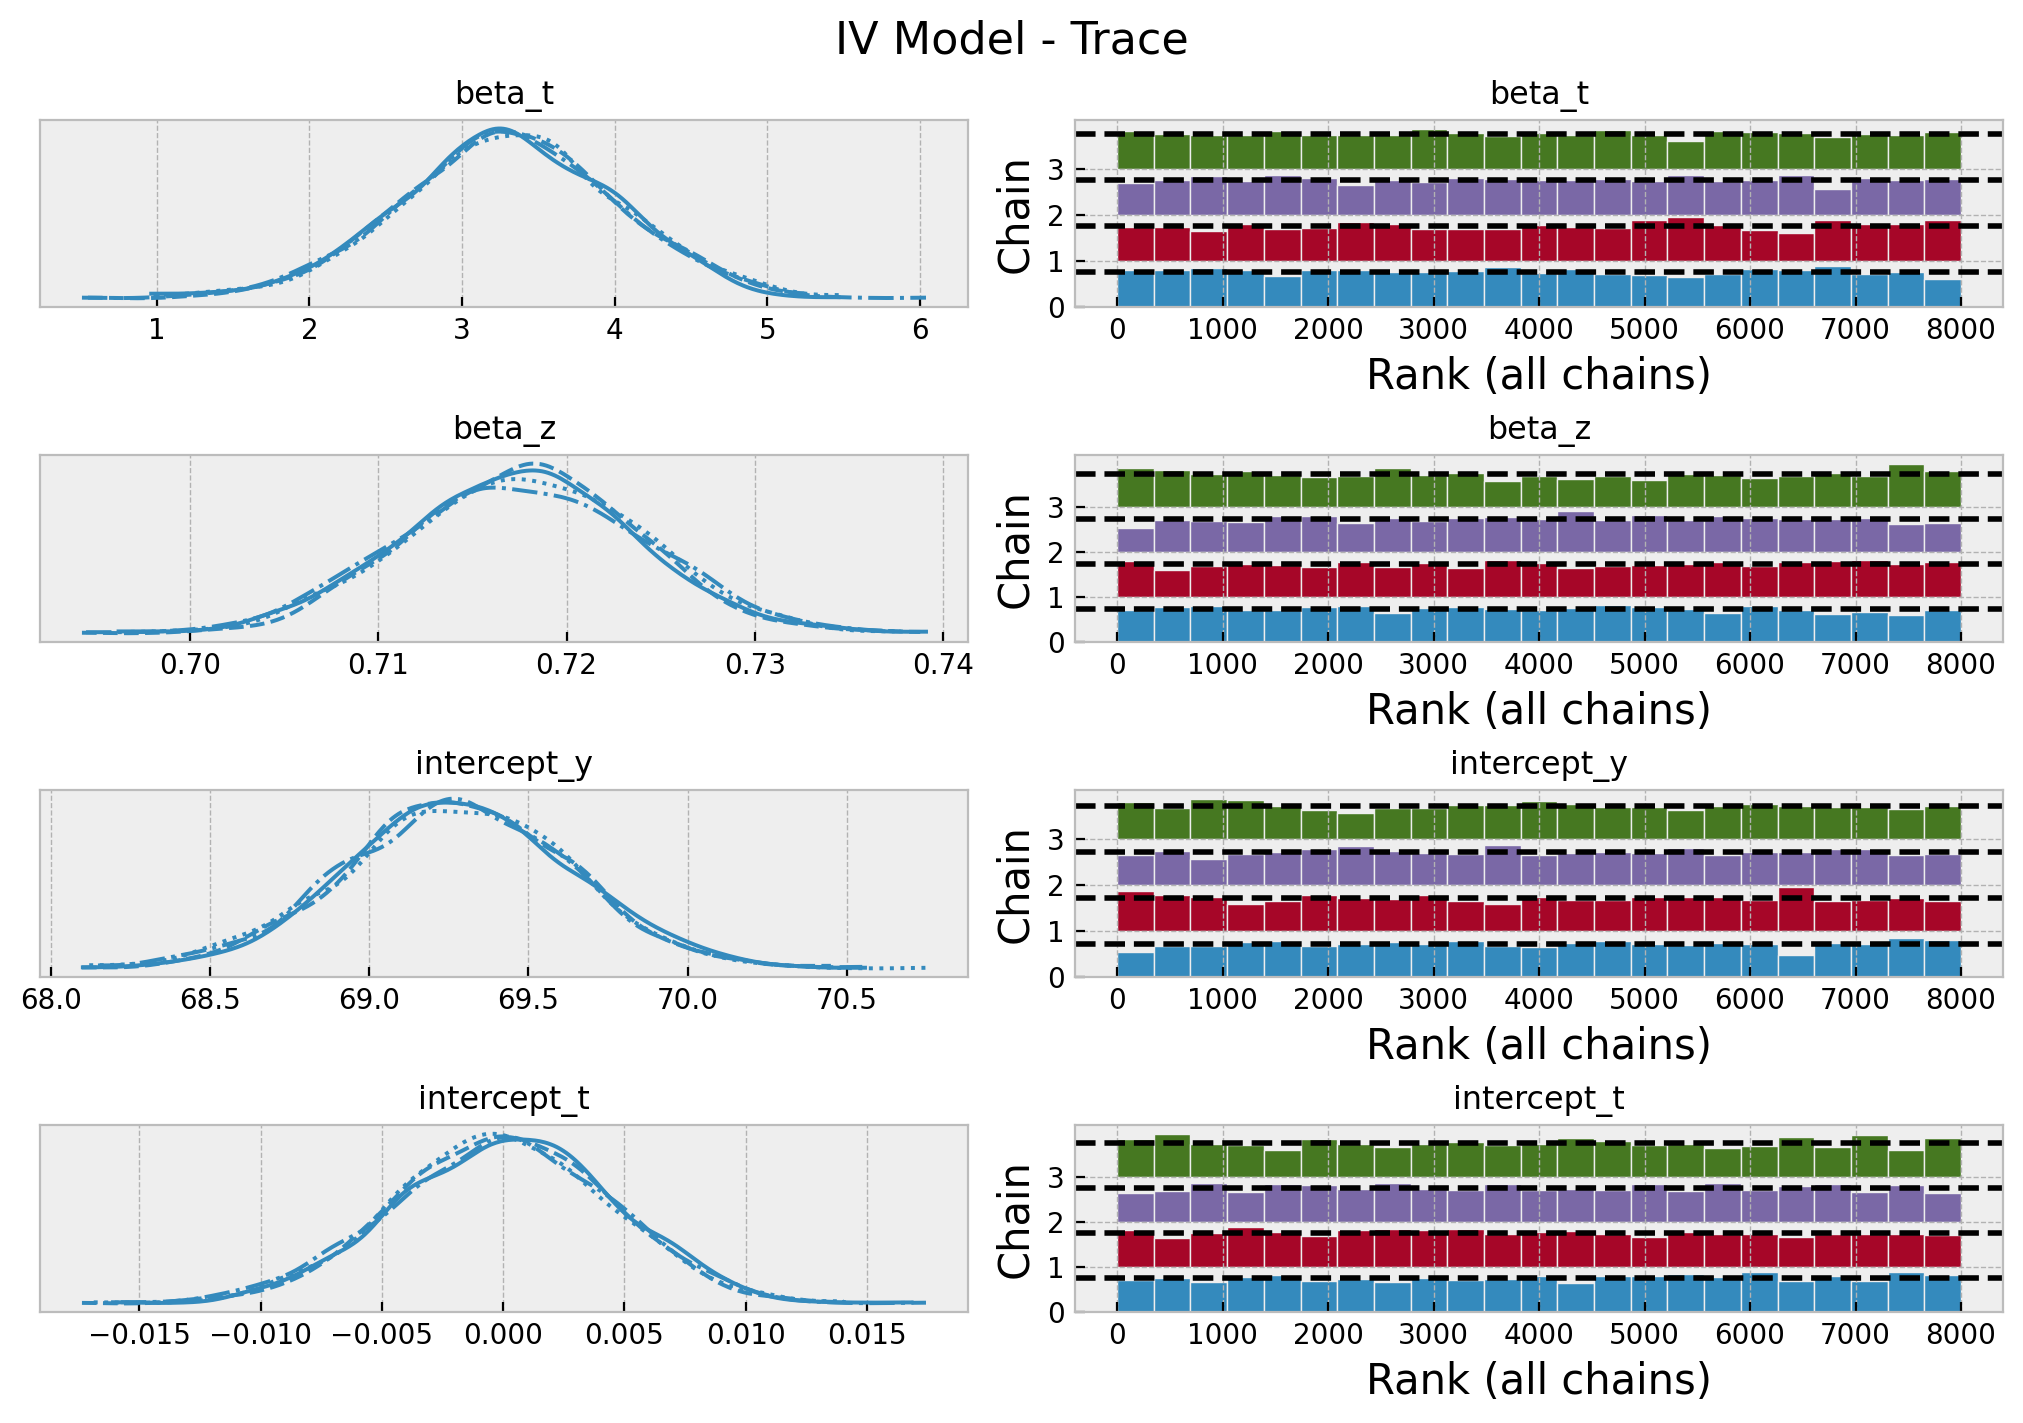

In [14]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 7), "layout": "constrained"},
)
plt.gcf().suptitle("IV Model - Trace", fontsize=16);

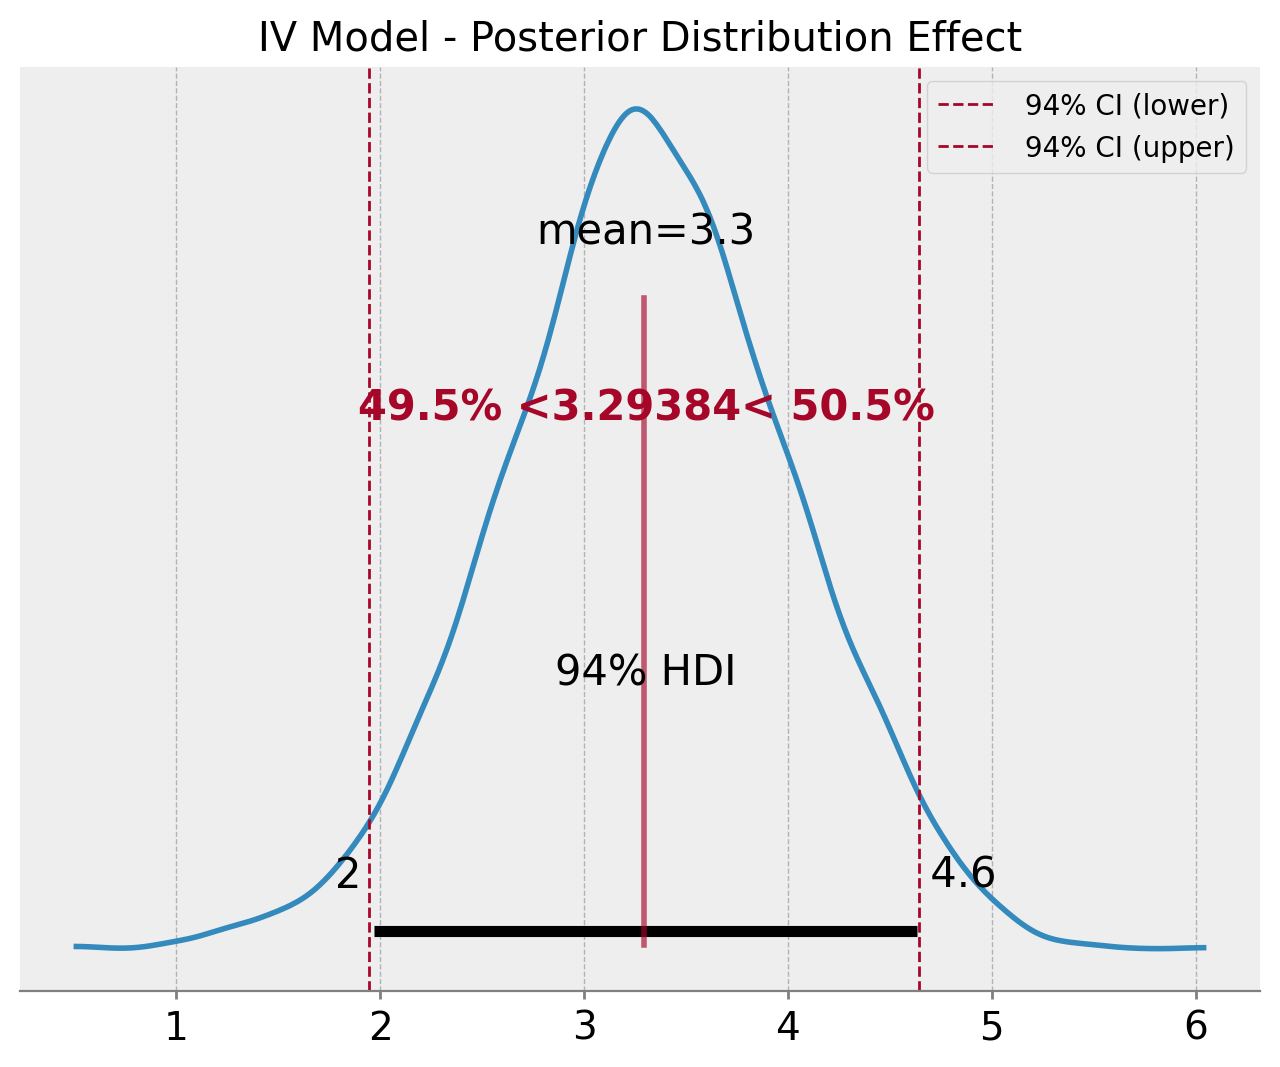

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
hdi_prob = 0.94
az.plot_posterior(
    data=idata,
    var_names=["beta_t"],
    ref_val=iv.params["push_delivered"],
    hdi_prob=hdi_prob,
    ax=ax,
)
ax.axvline(
    x=iv.conf_int(level=hdi_prob).loc["push_delivered", "lower"],
    color="C1",
    ls="--",
    lw=1,
    label=f"{hdi_prob: .0%} CI (lower)",
)
ax.axvline(
    x=iv.conf_int(level=hdi_prob).loc["push_delivered", "upper"],
    color="C1",
    ls="--",
    lw=1,
    label=f"{hdi_prob: .0%} CI (upper)",
)
ax.legend()
ax.set(title="IV Model - Posterior Distribution Effect");

[Text(0.5, 1.0, 'IV Model - Posterior Distribution Correlation')]

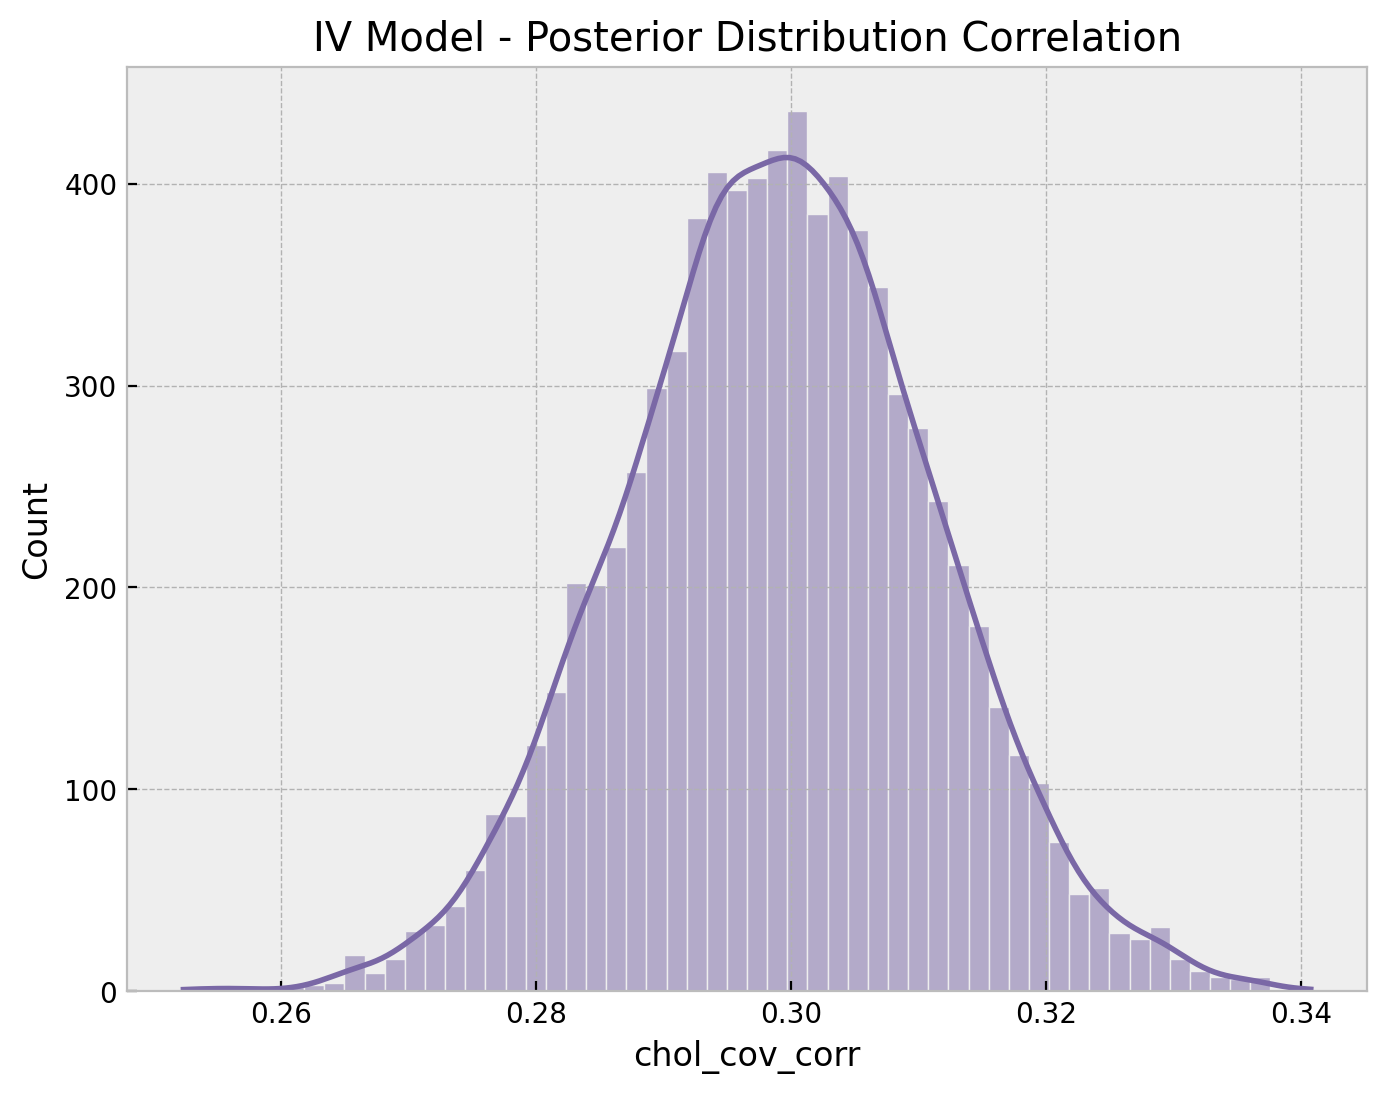

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(
    x=az.extract(data=idata, var_names=["chol_cov_corr"])[0, 1, :],
    kde=True,
    color="C2",
    ax=ax,
)
ax.set(title="IV Model - Posterior Distribution Correlation")


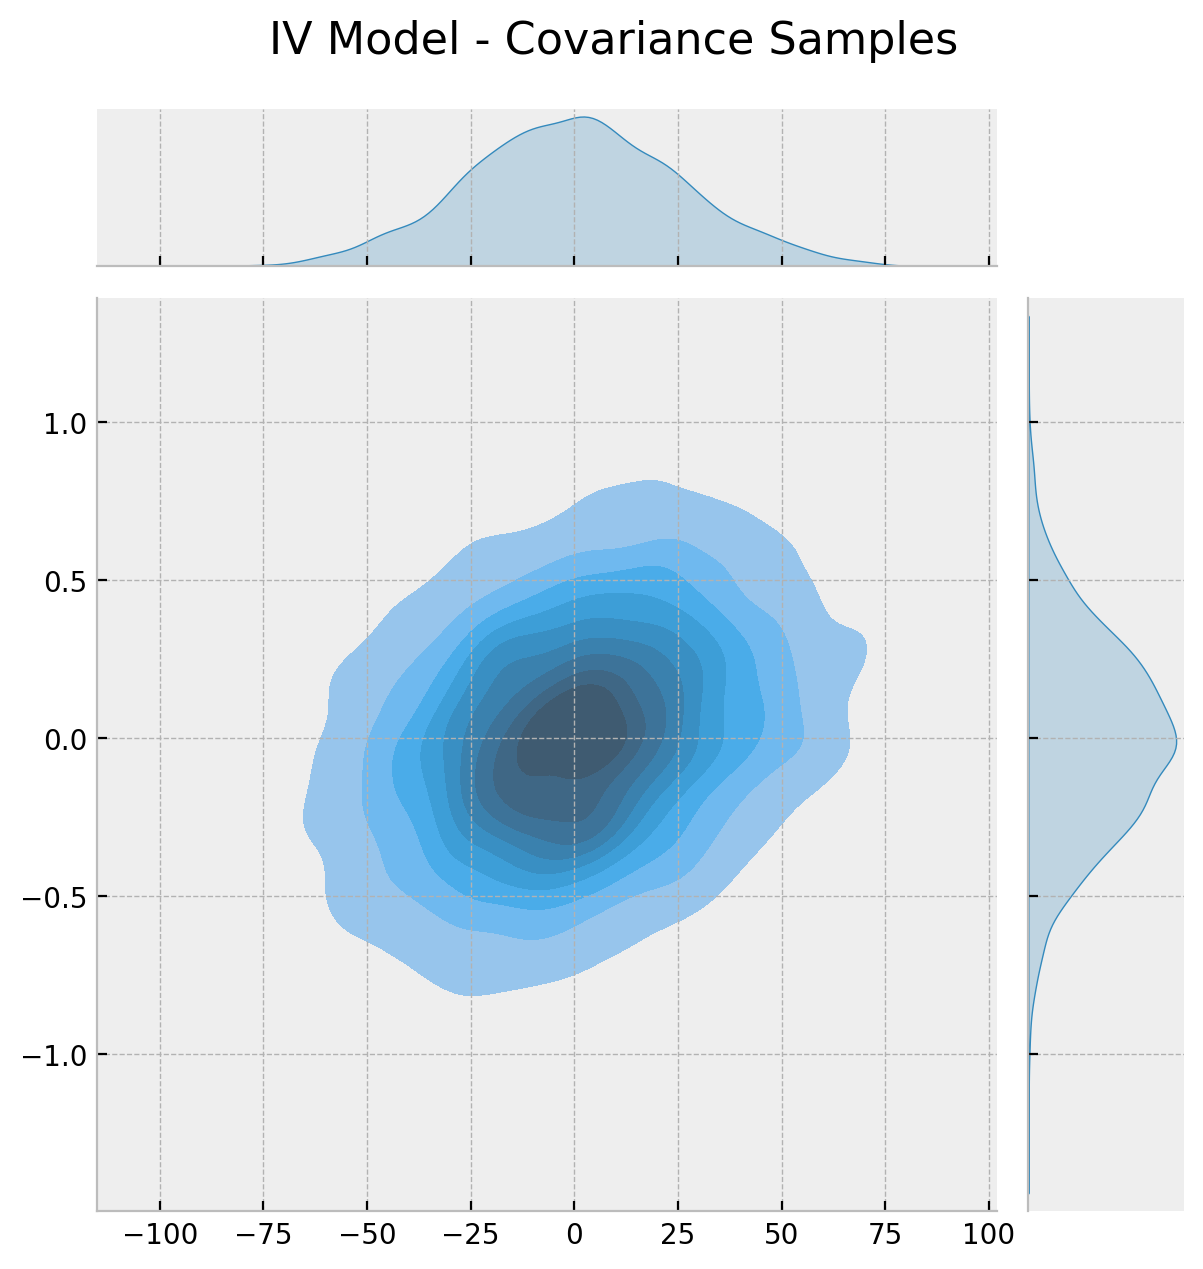

In [20]:
cov_mean = idata.posterior["cov"].mean(dim=("chain", "draw"))

cov_samples = np.random.multivariate_normal(
    mean=np.zeros(shape=(2)), cov=cov_mean, size=5_000
)

g = sns.jointplot(x=cov_samples[:, 0], y=cov_samples[:, 1], kind="kde", fill=True, height=6)
g.fig.suptitle("IV Model - Covariance Samples", fontsize=16, y=1.05);